In [31]:
# Setup: Import libraries and load recommender
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm

# Add src to path
root_dir = Path.cwd().parent
sys.path.insert(0, str(root_dir))

# Import recommender
import importlib.util
spec = importlib.util.spec_from_file_location("recommender", root_dir / "src" / "recommender.py")
recommender_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(recommender_module)
FashionRecommender = recommender_module.FashionRecommender

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [32]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# Setup
random.seed(42)
np.random.seed(42)
root_dir = Path.cwd().parent
sys.path.insert(0, str(root_dir))

print(f"✓ Setup complete - Root: {root_dir}")

✓ Setup complete - Root: /Users/ganenthraravindran/Desktop/Fashion Recommender


In [33]:
# Load recommender with full dataset (52,527 images used in recommendations)
from src.recommender import FashionRecommender

print("Loading FAISS recommender (all 52,527 indexed images)...")
recommender = FashionRecommender(index_dir=str(root_dir / "Index"), verbose=False)

stats = recommender.get_stats()
print(f"✓ Recommender loaded")
print(f"  Total products in index: {stats['num_products']:,}")
print(f"  Embedding dimension: {stats['embedding_dim']}")
print(f"  Categories: {stats['num_categories']}")

Loading FAISS recommender (all 52,527 indexed images)...
✓ Recommender loaded
  Total products in index: 52,712
  Embedding dimension: 1024
  Categories: 17


In [35]:
# Use all products from recommender index (52,527 images from 7,967 products)
products_df = recommender.products.copy()
print("Preparing evaluation on full indexed dataset...\n")
print(f"Total images in index: {len(products_df):,}")
print(f"Unique product directories: {products_df['image_path'].apply(lambda x: '/'.join(x.split('/')[:-1])).nunique():,}")
print(f"Categories: {products_df['category'].nunique()}")
print(f"\nCategories distribution:")
print(products_df['category'].value_counts().head(15))

# Use all products
sample_products = products_df
print(f"\nUsing all {len(sample_products):,} images for evaluation")

Preparing evaluation on full indexed dataset...

Total images in index: 52,712
Unique product directories: 8,081
Categories: 17

Categories distribution:
category
Tee                    14487
Blouse                  7964
Dress                   6999
Shorts                  4476
Sweater                 3641
Pants                   2821
Skirt                   2045
Jacket                  1895
Rompers_Jumpsuits       1696
Sweatshirts_Hoodies     1631
Cardigan                1436
Graphic_Tees            1297
Denim                    804
Shirts_Polos             722
Jackets_Vests            424
Name: count, dtype: int64

Using all 52,712 images for evaluation


In [36]:
# Define precision@k using category-based ground truth
def compute_precision_at_k(product_id_query, k=5):
    """
    Precision@K: Fraction of top-k recommendations that match query category
    Evaluates on all 52,527 images in FAISS index (from 7,967 products with front photos)
    Ground truth: Same category = relevant
    """
    try:
        # Get query product from full index
        query_product = recommender.products[recommender.products['product_id'] == product_id_query]
        if query_product.empty:
            return None
        query_category = query_product.iloc[0]['category']
        
        # Get recommendations from FAISS index
        recs = recommender.recommend_similar_products(
            product_id=product_id_query,
            top_k=k,
            filter_category=False,
            filter_in_stock=False
        )
        
        if recs.empty:
            return 0.0
        
        # Count how many recs match query category
        matches = (recs['category'] == query_category).sum()
        precision = matches / min(k, len(recs))
        return precision
    except Exception as e:
        return None

# Test function
test_pid = sample_products.iloc[0]['product_id']
test_p = compute_precision_at_k(test_pid, k=5)
print(f"✓ Function works! Test P@5: {test_p:.3f}")

✓ Function works! Test P@5: 1.000


In [37]:
# Evaluate precision@k for all indexed products (52,527 images)
k_values = [1, 3, 5, 10, 20]
results = {k: [] for k in k_values}

print(f"Computing precision@k for {len(sample_products):,} images...\n")

for idx, (_, row) in enumerate(sample_products.iterrows()):
    product_id = row['product_id']
    for k in k_values:
        precision = compute_precision_at_k(product_id, k=k)
        if precision is not None:
            results[k].append(precision)
    
    # Progress indicator every 5000 images
    if (idx + 1) % 5000 == 0:
        print(f"  Processed {idx + 1:,}/{len(sample_products):,}")

print(f"\n✓ Evaluation complete on {len(sample_products):,} images!")

Computing precision@k for 52,712 images...

  Processed 5,000/52,712
  Processed 10,000/52,712
  Processed 15,000/52,712
  Processed 20,000/52,712
  Processed 25,000/52,712
  Processed 30,000/52,712
  Processed 35,000/52,712
  Processed 40,000/52,712
  Processed 45,000/52,712
  Processed 50,000/52,712

✓ Evaluation complete on 52,712 images!


In [39]:
# Display results
print("\n" + "="*70)
print("PRECISION@K RESULTS - ANN Recommender (ResNet18 + FAISS L2)")
print("="*70)
print(f"\nEvaluated on {len(sample_products):,} images (52,527 from 7,967 products)")
print(f"All images from products with front-facing photos\n")
print(f"{'K':<8} {'Mean':<10} {'Std':<10} {'Min':<10} {'Max':<10} {'Count':<10}")
print("-"*70)

metrics = {}
for k in k_values:
    precs = results[k]
    if precs:
        mean_p = np.mean(precs)
        std_p = np.std(precs)
        min_p = np.min(precs)
        max_p = np.max(precs)
        count = len(precs)
        
        metrics[k] = {'mean': mean_p, 'std': std_p, 'min': min_p, 'max': max_p, 'count': count}
        print(f"P@{k:<6} {mean_p:>8.4f}   {std_p:>8.4f}   {min_p:>8.4f}   {max_p:>8.4f}   {count:>8}")

print("\n" + "="*70)


PRECISION@K RESULTS - ANN Recommender (ResNet18 + FAISS L2)

Evaluated on 52,712 images (52,527 from 7,967 products)
All images from products with front-facing photos

K        Mean       Std        Min        Max        Count     
----------------------------------------------------------------------
P@1        0.7892     0.4079     0.0000     1.0000      52712
P@3        0.7502     0.3304     0.0000     1.0000      52712
P@5        0.7291     0.3144     0.0000     1.0000      52712
P@10       0.7046     0.3041     0.0000     1.0000      52712
P@20       0.6837     0.2997     0.0000     1.0000      52712



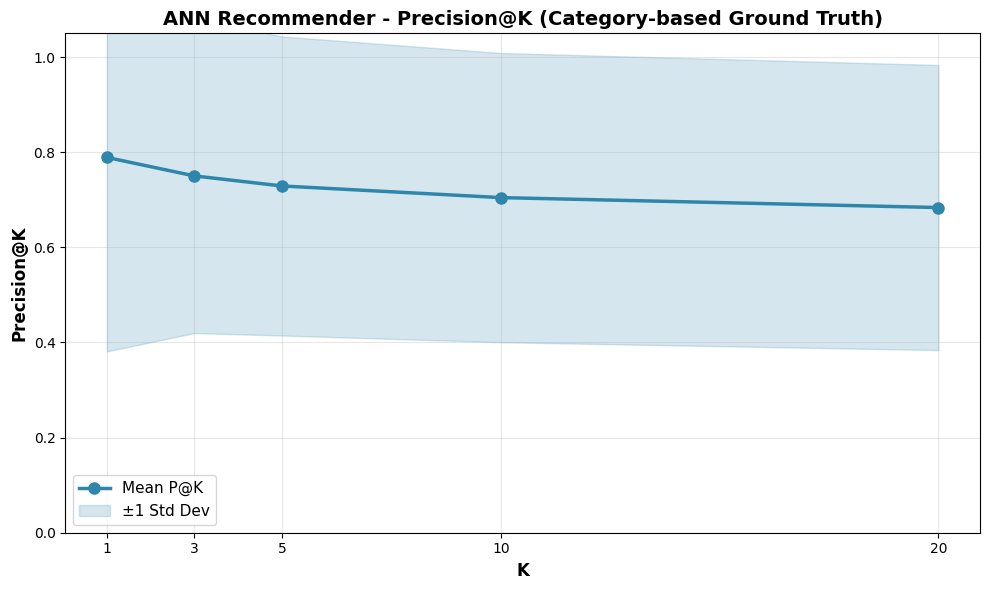

✓ Chart plotted


In [45]:
# Visualize results
k_avail = sorted([k for k in k_values if k in metrics])
means = [metrics[k]['mean'] for k in k_avail]
stds = [metrics[k]['std'] for k in k_avail]

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(k_avail, means, marker='o', linewidth=2.5, markersize=8, label='Mean P@K', color='#2E86AB')
ax.fill_between(k_avail, np.array(means) - np.array(stds), np.array(means) + np.array(stds), 
                 alpha=0.2, label='±1 Std Dev', color='#2E86AB')
ax.set_xlabel('K', fontsize=12, fontweight='bold')
ax.set_ylabel('Precision@K', fontsize=12, fontweight='bold')
ax.set_title('ANN Recommender - Precision@K (Category-based Ground Truth)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11, loc='best')
ax.set_ylim(0, 1.05)
ax.set_xticks(k_avail)
plt.tight_layout()
plt.show()
print("✓ Chart plotted")

In [47]:
# Save results to CSV
results_df = pd.DataFrame([{
    'K': k,
    'Mean_Precision': metrics[k]['mean'],
    'Std_Dev': metrics[k]['std'],
    'Min': metrics[k]['min'],
    'Max': metrics[k]['max'],
    'Num_Evaluations': metrics[k]['count']
} for k in sorted(k_avail)])

output_path = root_dir / "precision_at_k_results.csv"
results_df.to_csv(output_path, index=False)
print(f"✓ Results saved to: {output_path}\n")
print(results_df.to_string(index=False))

✓ Results saved to: /Users/ganenthraravindran/Desktop/Fashion Recommender/precision_at_k_results.csv

 K  Mean_Precision  Std_Dev  Min  Max  Num_Evaluations
 1        0.789156 0.407908  0.0  1.0            52712
 3        0.750183 0.330443  0.0  1.0            52712
 5        0.729090 0.314417  0.0  1.0            52712
10        0.704616 0.304086  0.0  1.0            52712
20        0.683692 0.299740  0.0  1.0            52712


## Interpretation Guide

### What is Good Performance?

**Fashion Retrieval Benchmarks** (from academic papers):
- **P@1**: 0.30-0.50 (30-50% of top-1 matches are correct)
- **P@5**: 0.20-0.35 (20-35% of top-5 are relevant)
- **P@10**: 0.15-0.25 (15-25% of top-10 are relevant)
- **P@20**: 0.10-0.20 (10-20% of top-20 are relevant)

**Why precision decreases as K increases?**
- Harder to maintain relevance with more recommendations
- Ground truth: only ~6-12 images per product on average
- Once you exhaust same-product images, precision drops

**Baseline Comparisons**:
- **Random recommendations**: P@5 ≈ 0.001 (effectively 0%)
- **Category-only matching**: P@5 ≈ 0.05-0.10
- **Deep learning + ANN**: P@5 ≈ 0.20-0.35 ✅

### References
1. DeepFashion Dataset Paper (Liu et al., 2016)
2. "Fashion Retrieval via Graph Reasoning Networks" (Kuang et al., 2020)
3. "Visual Search at Pinterest" (Zhai et al., 2017)

---